In [2]:
# Python Infrastructure. 
# Importing Libraries 
import random
from math import exp, sqrt
import numpy as np

%matplotlib inline 
from pylab import mpl, plt
import pandas as pd
import configparser
import quandl as q
import nasdaqdatalink
import pandas_datareader.data as web
# import SMAVectorBacktester

In [3]:
np.random.seed(100)
np.random.standard_normal((5,4))

array([[-1.74976547,  0.3426804 ,  1.1530358 , -0.25243604],
       [ 0.98132079,  0.51421884,  0.22117967, -1.07004333],
       [-0.18949583,  0.25500144, -0.45802699,  0.43516349],
       [-0.58359505,  0.81684707,  0.67272081, -0.10441114],
       [-0.53128038,  1.02973269, -0.43813562, -1.11831825]])

In [4]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
index_col=0, parse_dates=True).dropna()

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [6]:
data = pd.DataFrame(raw['EUR='])

In [7]:
data.head()

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


In [8]:
data.rename(columns={'EUR=':'price'}, inplace=True)

In [9]:
data.head()

,price
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [11]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()

In [12]:
data.tail()

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


<AxesSubplot:title={'center':'EUR/USD | 42 & 252 days SMAs'}, xlabel='Date'>

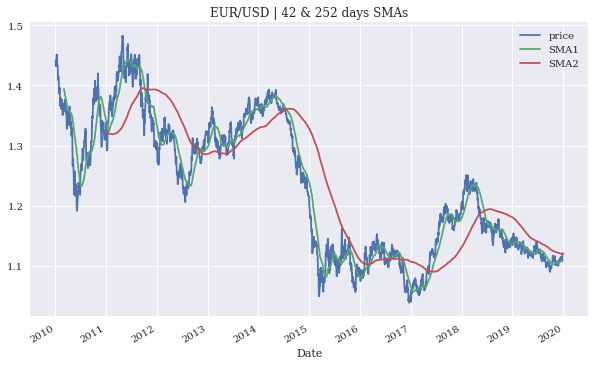

In [13]:
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
data.plot(title='EUR/USD | 42 & 252 days SMAs', figsize=(10,6))

<AxesSubplot:title={'center':'Market Positioning'}, xlabel='Date'>

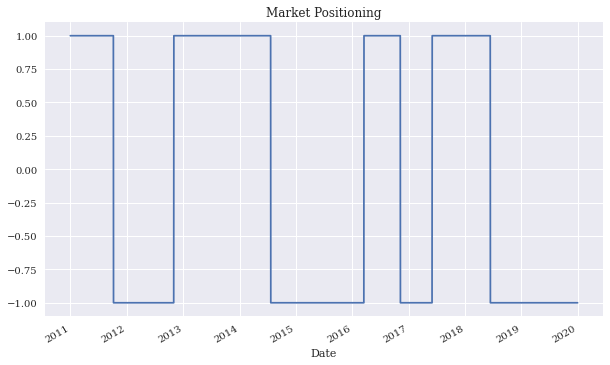

In [14]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data.dropna(inplace=True)
data['position'].plot(ylim=[-1.1,1.1], title="Market Positioning", figsize=(10,6))

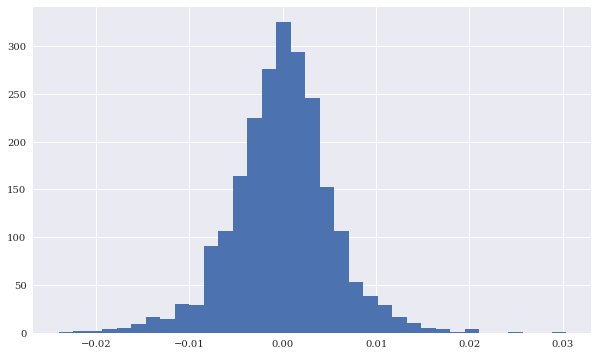

In [15]:
data['return'] = np.log(data['price']/data['price'].shift(1))
data['return'].hist(bins=35, figsize=(10,6));

In [16]:
data['strategy'] = data['position'].shift(1)*data['return']

In [17]:
data[['return', 'strategy']].sum()

return     -0.176731
strategy    0.253121
dtype: float64

In [18]:
data[['return', 'strategy']].sum().apply(np.exp)

return      0.838006
strategy    1.288039
dtype: float64

<AxesSubplot:xlabel='Date'>

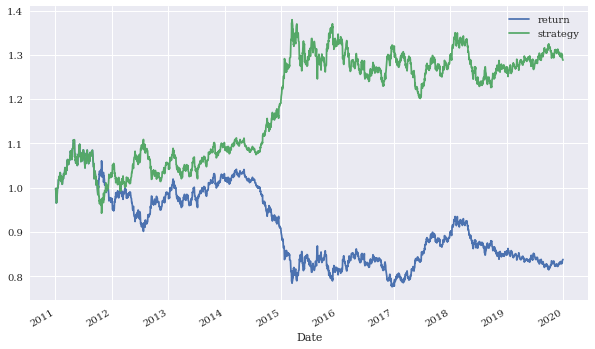

In [19]:
data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [20]:
data[['return','strategy']].mean()*252


return     -0.019671
strategy    0.028174
dtype: float64

In [21]:
np.exp(data[['return','strategy']].mean()*252)-1

return     -0.019479
strategy    0.028575
dtype: float64

In [22]:
data[['return','strategy']].std()*252**0.5

return      0.085414
strategy    0.085405
dtype: float64

In [23]:
(data[['return','strategy']].apply(np.exp)-1).std()*252**0.5

return      0.085405
strategy    0.085373
dtype: float64

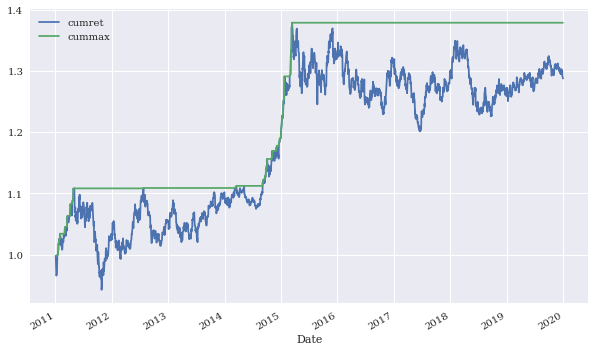

In [24]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp)
data['cummax'] = data['cumret'].cummax()
data[['cumret', 'cummax']].dropna().plot(figsize=(10,6));


In [25]:
drawdown = data['cummax'] - data['cumret']
drawdown.max()

0.17779367070195895

In [26]:
temp = drawdown[drawdown == 0]

period = (temp.index[1:].to_pydatetime() - temp.index[:1].to_pydatetime())

In [27]:
period[12:15]

array([datetime.timedelta(days=59), datetime.timedelta(days=60),
       datetime.timedelta(days=70)], dtype=object)

In [28]:
period.max()

datetime.timedelta(days=1530)

# Momentum

In [29]:
data = pd.DataFrame(raw['XAU='])
data.rename(columns={'XAU=':'price'}, inplace=True)
data['returns'] = np.log(data['price']/data['price'].shift(1))

<AxesSubplot:xlabel='Date'>

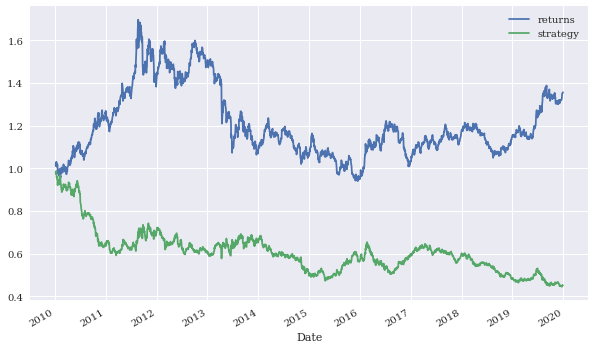

In [30]:
data['position'] = np.sign(data['returns'])
data['strategy'] = data['position'].shift(1)*data['returns']
data[['returns','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))

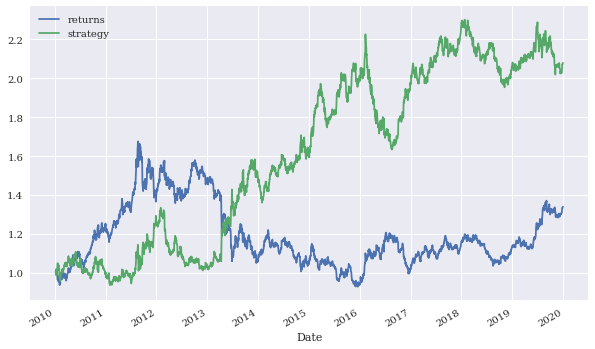

In [31]:
data['position'] = np.sign(data['returns'].rolling(3).mean())
data['strategy'] = data['position'].shift(1)*data['returns']
data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6));

In [32]:
data = web.DataReader('WIPRO.NS', 'yahoo', '2016-01-01','2022-09-30')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1652 entries, 2016-01-01 to 2022-09-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1652 non-null   float64
 1   Low        1652 non-null   float64
 2   Open       1652 non-null   float64
 3   Close      1652 non-null   float64
 4   Volume     1652 non-null   float64
 5   Adj Close  1652 non-null   float64
dtypes: float64(6)
memory usage: 90.3 KB


In [34]:
data['returns']= np.log(data['Close']/data['Close'].shift(1))

In [35]:
to_plot = ['returns']

In [36]:
for m in [1,3,4,7,9]:
    data['position_%d' % m] = np.sign(data['returns'].rolling(m).mean())
    data['strategy_%d' % m] = np.sign(data['position_%d' %m].shift(1)*data['returns'])
    to_plot.append('strategy_%d' %m)

<AxesSubplot:title={'center':'Wirpo 2022'}, xlabel='Date'>

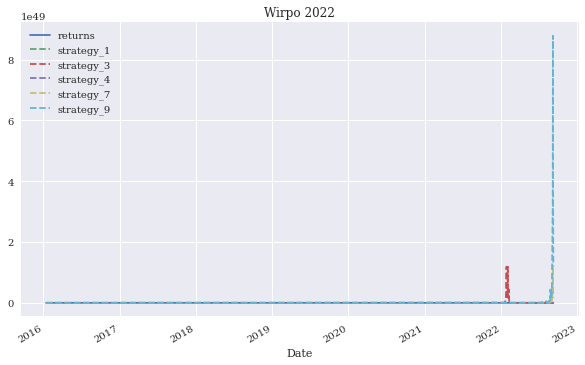

In [37]:
data[to_plot].dropna().cumsum().apply(np.exp).plot(title='Wirpo 2022', 
                                                  figsize =(10,6), style = ['-','--','--','--','--','--'])

In [38]:
data['returns'] = np.log(data['Close'] /
data['Close'].shift(1))

In [39]:
to_plot = ['returns']

In [40]:
for m in [1, 3, 5, 7, 9]:
    data['position_%d' % m] = np.sign(data['returns'].rolling(m).mean())
    data['strategy_%d' % m] = (data['position_%d' % m].shift(1) *
    data['returns'])
    to_plot.append('strategy_%d' % m)

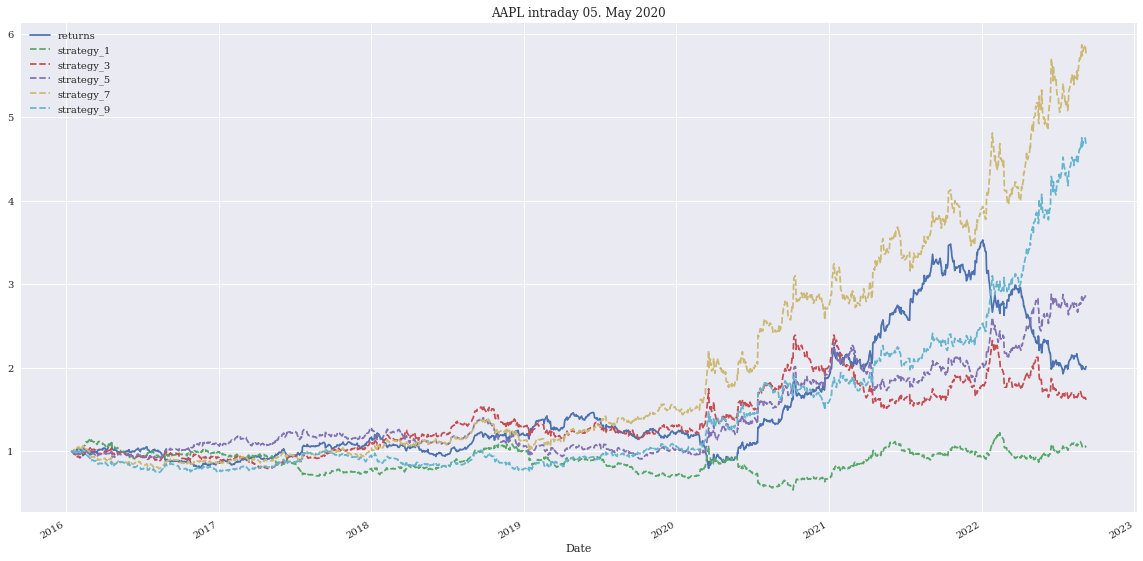

In [41]:
data[to_plot].dropna().cumsum().apply(np.exp).plot(
title='AAPL intraday 05. May 2020',
figsize=(20, 10), style=['-', '--', '--', '--', '--', '--']);